# Notebook for BNN and XNOR-Net Training
Using Kannada MNIST Dataset

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from CustomOps.customOps import SetSession

# Call this first here, to make sure that Tensorflow registers our custom ops properly
SetSession()

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, BatchNormalization, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from CompositeLayers.ConvBNReluLayer import ConvBNReluLayer
from CompositeLayers.BinaryNetConvBNReluLayer import BinaryNetConvBNReluLayer, BinaryNetActivation
from CustomLayers.CustomLayersDictionary import customLayersDictionary
from CompositeLayers.XNORConvLayer import XNORConvBNReluLayer, BNXNORConvReluLayer
from NetworkParameters import NetworkParameters
from CustomLayers.CustomLayersDictionary import customLayerCallbacks

np.random.seed(198)

Instructions for updating:
non-resource variables are not supported in the long term
2.2.0



Using TensorFlow backend.


# Create model

In [30]:
# Binarized convolution neural network
def Create_BNN(input_shape, nb_classes, binarisation_type):
    model_input = Input(shape=input_shape)

    output = model_input

    if binarisation_type == 'BinaryNet':
        print('Using BinaryNet binary convolution layers')
        layerType = BinaryNetConvBNReluLayer
    elif binarisation_type == 'XNORNet':
        print('Using XNORNet binary convolution layers')
        layerType = BNXNORConvReluLayer
    else:
        assert False, 'Unsupported binarisation type!'

    # As per the paper, the first layer can't be binary
    output = ConvBNReluLayer(input=output, nb_filters=16, border='valid', kernel_size=(3, 3), stride=(1, 1))

    output = layerType(input=output, nb_filters=32, border='valid', kernel_size=(3, 3), stride=(1, 1))
    output = layerType(input=output, nb_filters=32, border='valid', kernel_size=(3, 3), stride=(1, 1))
    output = layerType(input=output, nb_filters=32, border='valid', kernel_size=(3, 3), stride=(1, 1))
    output = layerType(input=output, nb_filters=32, border='valid', kernel_size=(3, 3), stride=(1, 1))
    output = layerType(input=output, nb_filters=32, border='valid', kernel_size=(3, 3), stride=(1, 1))
    output = MaxPooling2D((2, 2))(output)
    output = Flatten()(output)
    output = Dense(nb_classes, use_bias=True, activation='softmax')(output)

    model = Model(inputs=model_input, outputs=output, name=binarisation_type)

    model.summary()

    return model

# Data Preparation

In [2]:
data = pd.read_csv("../input/kan_mnist.csv")
classname = [str(n) for n in data.label.unique()]

X, y = [],[]
for i in range(len(data)):
    re_X, re_y = data.iloc[i, 1:].values.reshape(28,28), data.iloc[i].label   
    X.append(np.array(re_X))
    y.append(np.array(re_y))
    
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

# data split
X_train, y_train = X[:50000], y[:50000] 
X_test, y_test = X[50000:], y[50000:] 

if len(X_train.shape) < 4:
    X_train = np.expand_dims(X_train, -1)
    X_test = np.expand_dims(X_test, -1)

input_shape = X_train.shape[1:]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize data
X_train = X_train / 256.0
X_test = X_test / 256.0

nb_classes = y_train.max()+1

# label to categorical 
y_test_cat = to_categorical(y_test, nb_classes)
y_train_cat = to_categorical(y_train, nb_classes)

(60000, 28, 28) (60000,)


# Parameters

In [32]:
modelDirectory = os.getcwd()

parameters = NetworkParameters(modelDirectory)
parameters.nb_epochs = 10
parameters.batch_size = 32
parameters.lr = 0.0005
parameters.batch_scale_factor = 8
parameters.decay = 0.001

# parameters.binarisation_type = 'XNORNet' # Either 'BinaryNet' or 'XNORNet'

parameters.lr *= parameters.batch_scale_factor
parameters.batch_size *= parameters.batch_scale_factor

print('Learning rate is: %f' % parameters.lr)
print('Batch size is: %d' % parameters.batch_size)

optimiser = Adam(lr=parameters.lr, decay=parameters.decay)

Learning rate is: 0.004000
Batch size is: 256


# XNOR-Net

# _

# Build model

In [36]:
xnor_model = Create_BNN(input_shape=input_shape, nb_classes=nb_classes, binarisation_type='XNORNet')

xnor_model.compile(loss='categorical_crossentropy',
              optimizer=optimiser,
              metrics=['accuracy'])

Using XNORNet binary convolution layers
Tensor("xnor_net_conv2d_10/Mean:0", shape=(?, 26, 26, 1), dtype=float32)
Tensor("xnor_net_conv2d_11/Mean:0", shape=(?, 24, 24, 1), dtype=float32)
Tensor("xnor_net_conv2d_12/Mean:0", shape=(?, 22, 22, 1), dtype=float32)
Tensor("xnor_net_conv2d_13/Mean:0", shape=(?, 20, 20, 1), dtype=float32)
Tensor("xnor_net_conv2d_14/Mean:0", shape=(?, 18, 18, 1), dtype=float32)
Model: "XNORNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_12 (Batc (None, 26, 26, 16)        64        
_________________________________________________________________
activation_12 (Activation)   (None, 26, 26, 16)   

In [6]:
# plot_model(xnor_model, to_file=os.path.join(os.getcwd(), 'results/arch/xnor_arch.png'),
#                                   show_shapes=True, show_layer_names=False)

# Training

In [37]:
xnor_history = xnor_model.fit(x=X_train,
          y=y_train_cat,
          batch_size=parameters.batch_size,
          epochs=parameters.nb_epochs,
          callbacks=customLayerCallbacks,
          validation_data=(X_test, y_test_cat),
          shuffle=True,
          verbose=1
          )

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 103s 2ms/sample - loss: 0.2482 - acc: 0.9291 - val_loss: 0.5086 - val_acc: 0.9481
Epoch 2/10
50000/50000 [==============================] - 110s 2ms/sample - loss: 0.0500 - acc: 0.9839 - val_loss: 0.0742 - val_acc: 0.9808
Epoch 3/10
50000/50000 [==============================] - 108s 2ms/sample - loss: 0.0384 - acc: 0.9879 - val_loss: 0.1030 - val_acc: 0.9725
Epoch 4/10
50000/50000 [==============================] - 104s 2ms/sample - loss: 0.0360 - acc: 0.9886 - val_loss: 0.0564 - val_acc: 0.9827
Epoch 5/10
50000/50000 [==============================] - 103s 2ms/sample - loss: 0.0296 - acc: 0.9906 - val_loss: 0.1058 - val_acc: 0.9689
Epoch 6/10
50000/50000 [==============================] - 102s 2ms/sample - loss: 0.0278 - acc: 0.9911 - val_loss: 0.2512 - val_acc: 0.9412
Epoch 7/10
50000/50000 [==============================] - 102s 2ms/sample - loss: 0.0253 - acc: 0.9920 - val_l

# Evaluation

In [39]:
def plot_training(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    plt.title("CNN")
    ax1.plot(history.history['loss'], color='b', label="Training loss", linewidth=2)
    ax1.plot(history.history['val_loss'], color='r', label="validation loss", linewidth=2)
    ax1.set_xticks(np.arange(0, parameters.nb_epochs, 1))
    ax1.title.set_text("Cross Entropy Loss (Training: "+str(round(history.history['loss'][-1],4))+", Validation: "+str(round(history.history['val_loss'][-1],4))+")")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc='best', shadow=False)

    ax2.plot(history.history['acc'], color='b', label="Training accuracy", linewidth=2)
    ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy", linewidth=2)
    ax2.set_xticks(np.arange(0, parameters.nb_epochs, 1))
    ax2.title.set_text("Accuracy (Training: "+str(round(history.history['acc'][-1]*100,2))+"%, Validation: "+str(round(history.history['val_acc'][-1]*100,2))+"%)")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc='lower right', shadow=False)
    plt.rcParams.update({'font.size': 10})
    
    plt.tight_layout()
    plt.savefig('results/xnor_train_plot.png', bbox_inches='tight', dpi=200)
    plt.show()

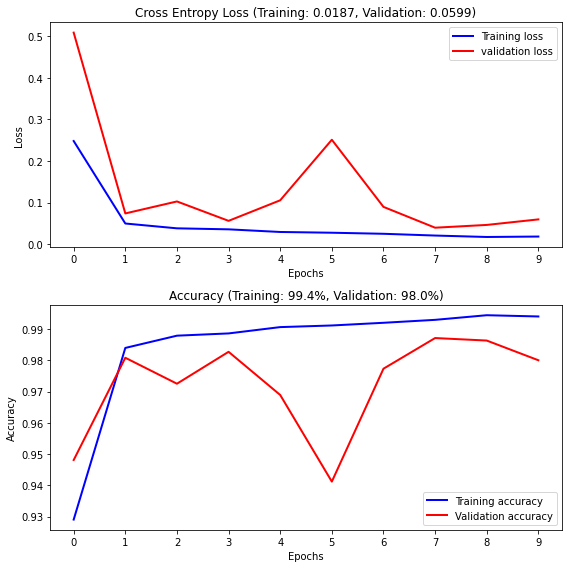

In [40]:
plot_training(xnor_history)

In [41]:
xnor_model.save('saved_models/xnor_model.h5')

In [3]:
xnorTest = load_model(filepath='saved_models/xnor_model.h5', custom_objects=customLayersDictionary)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
validationAccuracy = xnorTest.evaluate(X_test, y_test_cat, verbose=1)
print('\nBest Keras validation accuracy is : %f \n' % (100.0 * validationAccuracy[1]))


Best Keras validation accuracy is : 98.909998 



In [4]:
pred = xnorTest.predict(X_test)

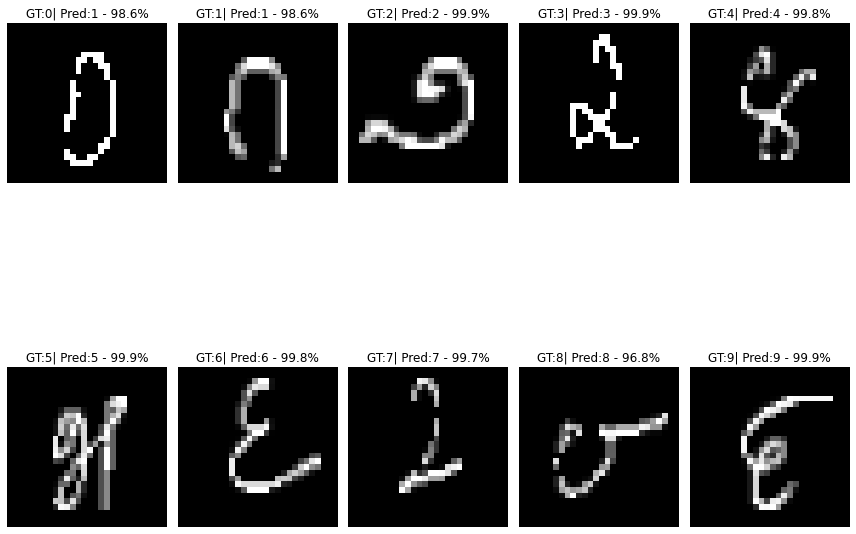

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(12,12))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(X_test[i], cmap=plt.get_cmap('gray'))
    ind = np.argmax(pred[i])
    ax.set_title(f"GT:{np.argmax(y_test_cat[i])}| Pred:{ind} - {str(np.max(pred[ind])*100)[:4]}%")
    ax.axis("off")
    
plt.tight_layout()
plt.savefig('results/xnor_pred.jpg',dpi=300)
plt.show()

# Confusion matrix 

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Test Dataset',
                          cmap=plt.cm.Blues,
                          save=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classname)
    plt.yticks(tick_marks, classname)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.tight_layout()
    sh = plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.colorbar(sh,fraction=0.046)
    if save!=0:
      plt.savefig(save+'_cm.jpg',dpi=300)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1000
           1       1.00      0.93      0.96      1000
           2       0.98      1.00      0.99      1000
           3       0.99      0.99      0.99      1000
           4       0.99      0.96      0.98      1000
           5       0.97      0.97      0.97      1000
           6       0.97      0.98      0.97      1000
           7       0.98      0.98      0.98      1000
           8       1.00      1.00      1.00      1000
           9       0.99      0.99      0.99      1000

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



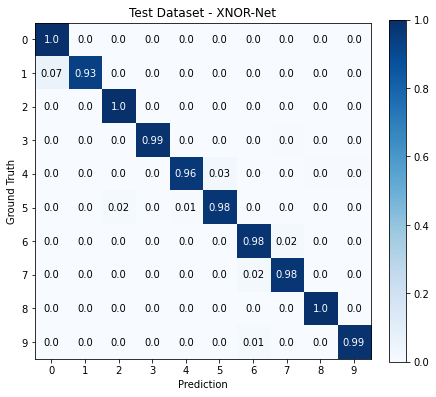

In [45]:
X_train_pred = np.argmax(pred,axis=1)
X_train_true = np.argmax(y_test_cat,axis=1)

f1_report = classification_report(X_train_true, X_train_pred, target_names=classname)
print(f1_report)
with open("results/xnor_f1_report.txt", "w") as f:
    f.write(f1_report)

train_confusion_mtx = confusion_matrix(X_train_true, X_train_pred) 
# plot the confusion matrix
plot_confusion_matrix(train_confusion_mtx,classes = range(len(classname)),title="Test Dataset - XNOR-Net", save='results/xnor') 
# plot_confusion_matrix(train_confusion_mtx,classes = range(len(classname)), save='output/latest_distress_v2_cnn_P92') 


# **********************************

# BNN

# _

In [17]:
bnn_model = Create_BNN(input_shape=input_shape, nb_classes=nb_classes, binarisation_type='BinaryNet')

bnn_model.compile(loss='categorical_crossentropy',
              optimizer=optimiser,
              metrics=['accuracy'])

Using BinaryNet binary convolution layers


ValueError: in user code:

    /mnt/5E982A95982A6BA9/ai_projects/binarized_neural_network/BinaryNet_and_XNORNet/CustomLayers/BinaryNetLayer.py:79 call  *
        return super().call(binarisedInput)
    /home/ndx/deepnet/lib/python3.6/site-packages/tensorflow/python/keras/layers/convolutional.py:194 call  **
        if self._recreate_conv_op(inputs):
    /home/ndx/deepnet/lib/python3.6/site-packages/tensorflow/python/keras/layers/convolutional.py:320 _recreate_conv_op
        for axis in range(1, len(call_input_shape)):
    /home/ndx/deepnet/lib/python3.6/site-packages/tensorflow/python/framework/tensor_shape.py:829 __len__
        raise ValueError("Cannot take the length of shape with unknown rank.")

    ValueError: Cannot take the length of shape with unknown rank.


In [ ]:
# plot_model(bnn_model, to_file=os.path.join(os.getcwd(), 'results/arch/bnn_arch.png'),
#                                   show_shapes=True, show_layer_names=False)

# Training

In [ ]:
bnn_history = bnn_model.fit(x=X_train,
          y=y_train_cat,
          batch_size=parameters.batch_size,
          epochs=parameters.nb_epochs,
          callbacks=customLayerCallbacks,
          validation_data=(X_test, y_test_cat),
          shuffle=True,
          verbose=1
          )

# Evaluation

In [ ]:
def plot_training(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    plt.title("CNN")
    ax1.plot(history.history['loss'], color='b', label="Training loss", linewidth=2)
    ax1.plot(history.history['val_loss'], color='r', label="validation loss", linewidth=2)
    ax1.set_xticks(np.arange(0, parameters.nb_epochs, 1))
    ax1.title.set_text("Loss (Training: "+str(round(history.history['loss'][-1],4))+", Validation: "+str(round(history.history['val_loss'][-1],4))+")")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc='best', shadow=False)

    ax2.plot(history.history['acc'], color='b', label="Training accuracy", linewidth=2)
    ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy", linewidth=2)
    ax2.set_xticks(np.arange(0, parameters.nb_epochs, 1))
    ax2.title.set_text("Accuracy (Training: "+str(round(history.history['acc'][-1]*100,2))+"%, Validation: "+str(round(history.history['val_acc'][-1]*100,2))+"%)")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc='lower right', shadow=False)
    plt.rcParams.update({'font.size': 10})
    
    plt.tight_layout()
    plt.savefig('results/bnn_train_plot.png', bbox_inches='tight', dpi=200)
    plt.show()

In [ ]:
plot_training(bnn_history)

In [ ]:
bnn_model.save('saved_models/bnn_model.h5')

In [ ]:
bnnTest = load_model(filepath='saved_models/bnn_model.h5', custom_objects=customLayersDictionary)

In [ ]:
validationAccuracy = bnnTest.evaluate(X_test, y_test_cat, verbose=1)
print('\nBest Keras validation accuracy is : %f \n' % (100.0 * validationAccuracy[1]))

In [ ]:
pred = bnnTest.predict(X_test)

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(8,8))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(X_test[i], cmap=plt.get_cmap('gray'))
    
    ax.set_title(f"GT:{np.argmax(y_test_cat[i])}| Pred:{np.argmax(pred[i])}")
    ax.axis("off")
    
plt.tight_layout()
plt.show()

# Confusion matrix 

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Test Dataset',
                          cmap=plt.cm.Blues,
                          save=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classname)
    plt.yticks(tick_marks, classname)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.tight_layout()
    sh = plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.colorbar(sh,fraction=0.046)
    if save!=0:
      plt.savefig(save+'_cm.jpg',dpi=300)

In [ ]:
X_train_pred = np.argmax(pred,axis=1)
X_train_true = np.argmax(y_test_cat,axis=1)

f1_report = classification_report(X_train_true, X_train_pred, target_names=classname)
print(f1_report)
with open("results/bnn_f1_report.txt", "w") as f:
    f.write(f1_report)

train_confusion_mtx = confusion_matrix(X_train_true, X_train_pred) 
# plot the confusion matrix
plot_confusion_matrix(train_confusion_mtx,classes = range(len(classname)),title="Test Dataset - BNN", save='results/bnn') 
# plot_confusion_matrix(train_confusion_mtx,classes = range(len(classname)), save='output/latest_distress_v2_cnn_P92') 

# *** *** ***

# Visualize

In [33]:
def get_all_feature_map(path, class_ind, model):
    for i in range(1,len(model.layers[:-2])):
        layer = model.layers[i].name
        print(layer)
        vis_model = Model(inputs=model.inputs, outputs=model.layers[13].output)
        # vis_model.summary()

        img = X_test[class_ind]
        img = np.expand_dims(img, axis=0)
        # get feature map for first hidden layer
        feature_maps = vis_model.predict(img)
        col = 8
        row = int(model.layers[i].output_shape[3]/col)
        ix = 1
        plt.figure(figsize=(10,10),tight_layout=1)
        for _ in range(row):
            for _ in range(col):
                # specify subplot and turn of axis
                ax = plt.subplot(row, col, ix)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(feature_maps[0, :, :, ix-1], interpolation='none')
                ix += 1
        # show the figure
        plt.savefig(f"{path}/{i}_{layer}_falsecolor.png", bbox_inches='tight', dpi=300)
        plt.show()

conv2d_2


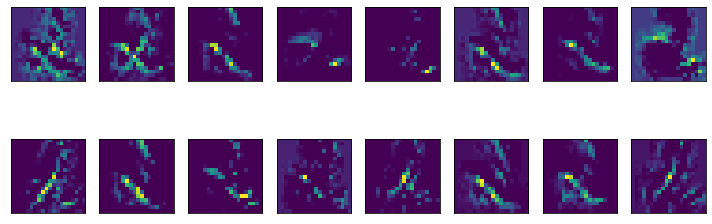

batch_normalization_12


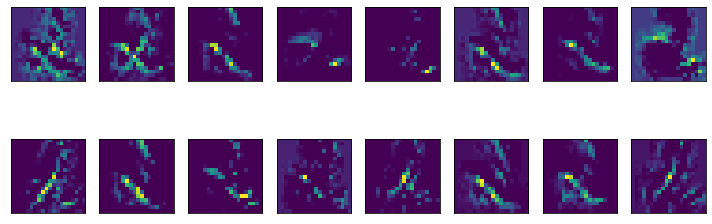

activation_12


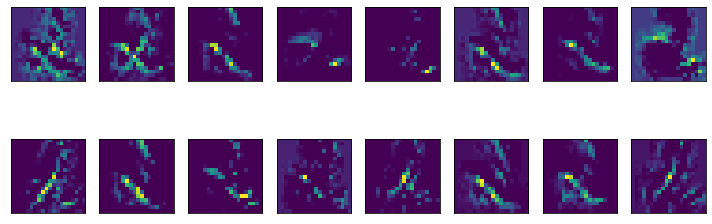

batch_normalization_13


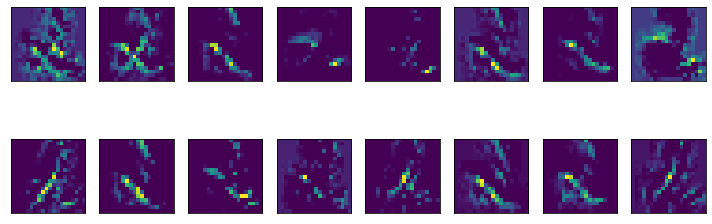

xnor_net_conv2d_10


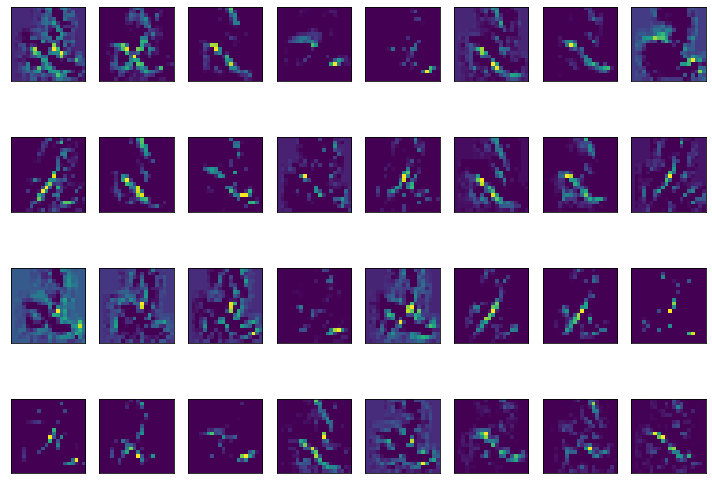

activation_13


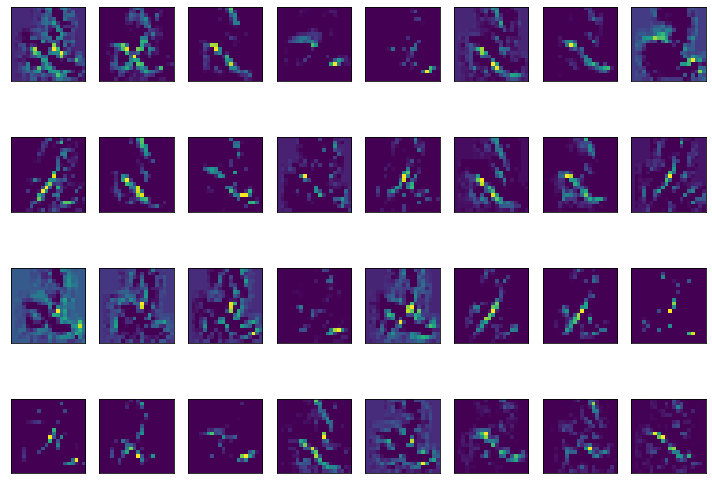

batch_normalization_14


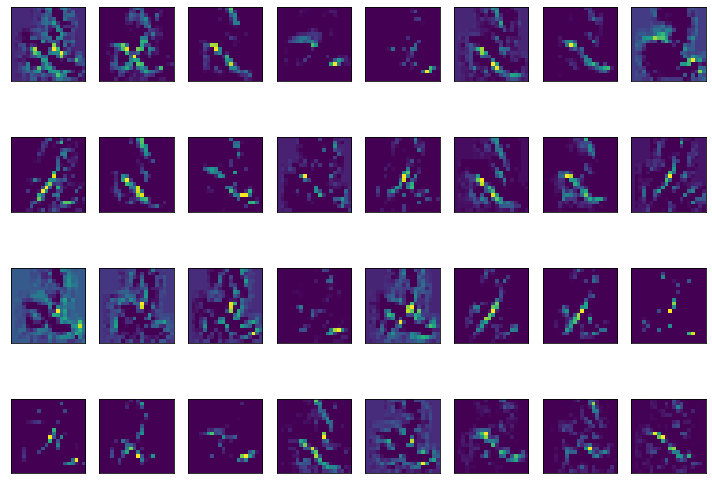

xnor_net_conv2d_11


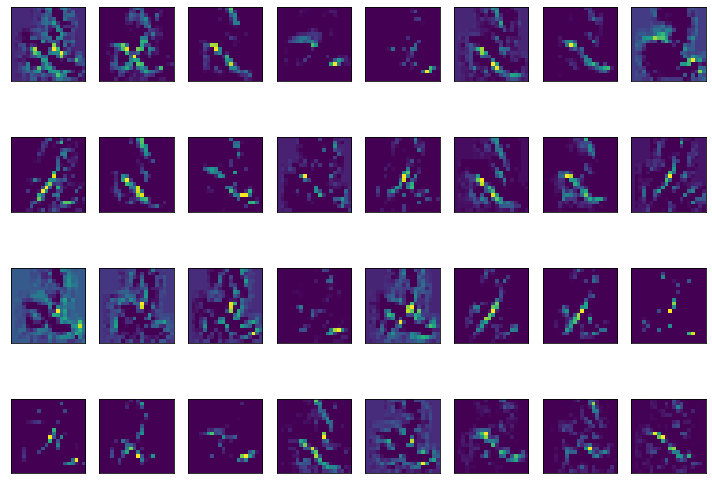

activation_14


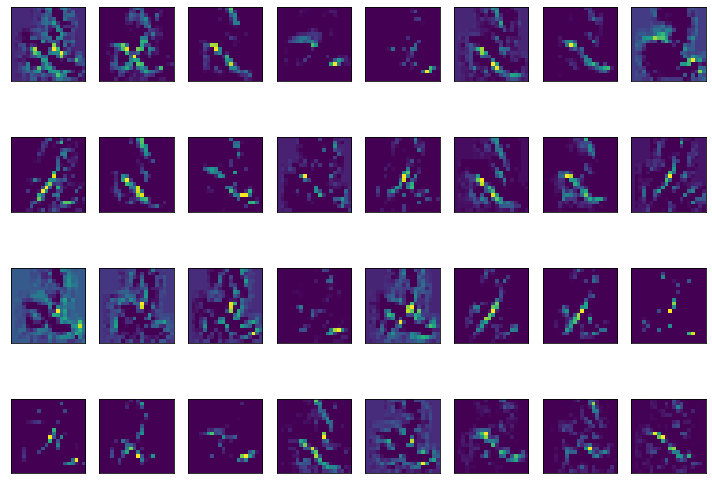

batch_normalization_15


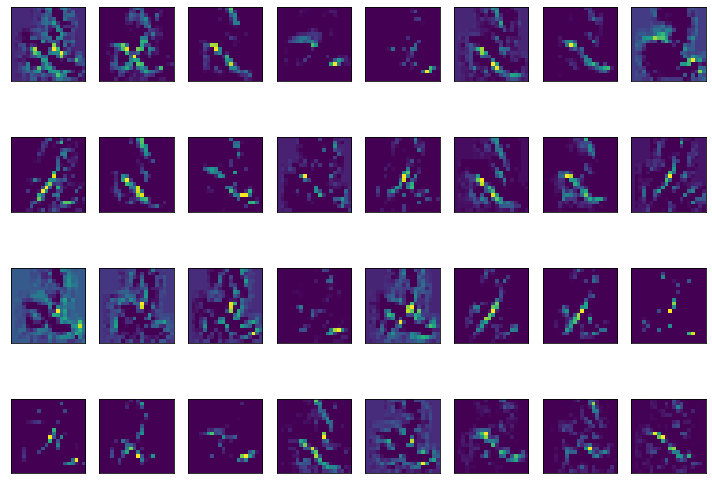

xnor_net_conv2d_12


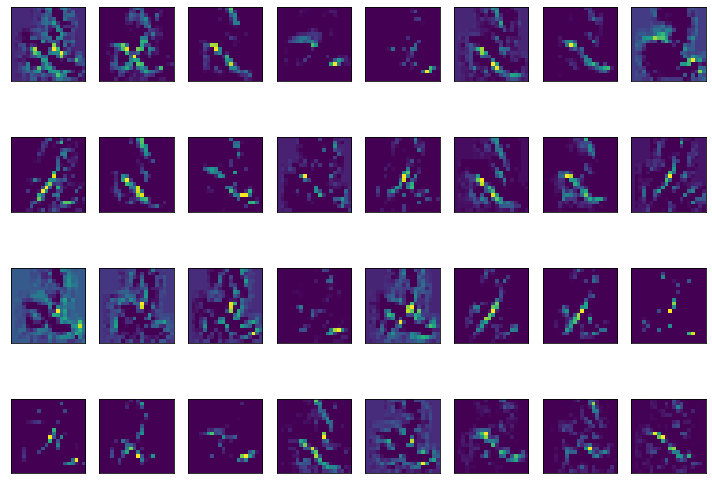

activation_15


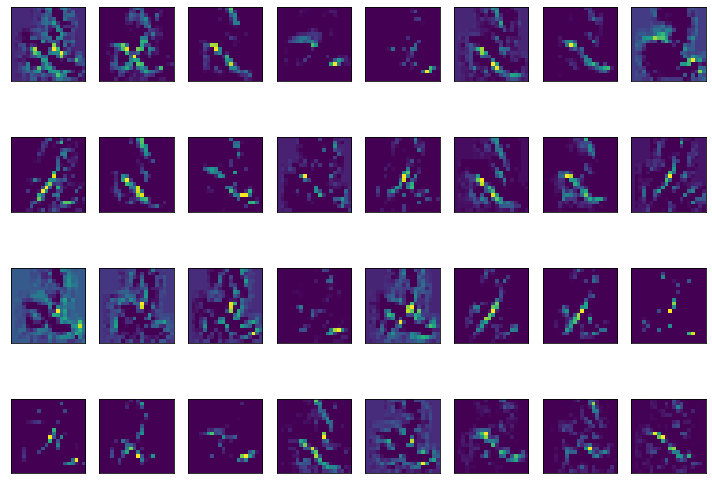

batch_normalization_16


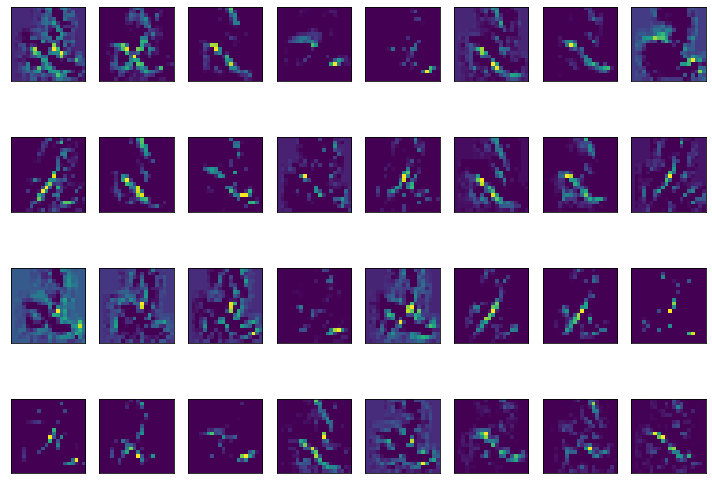

xnor_net_conv2d_13


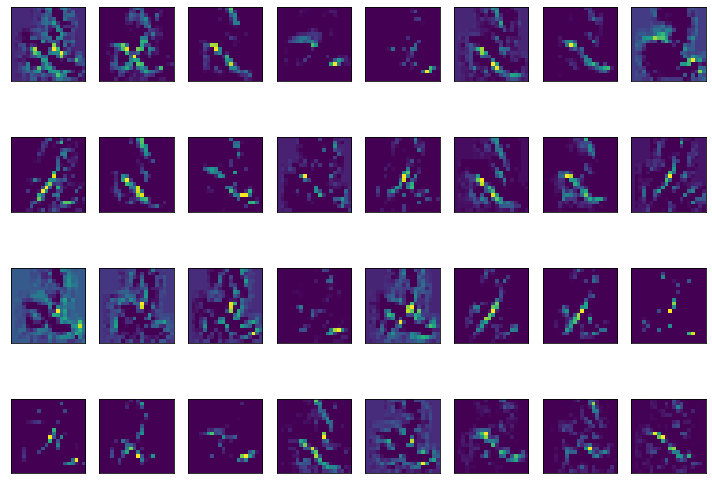

activation_16


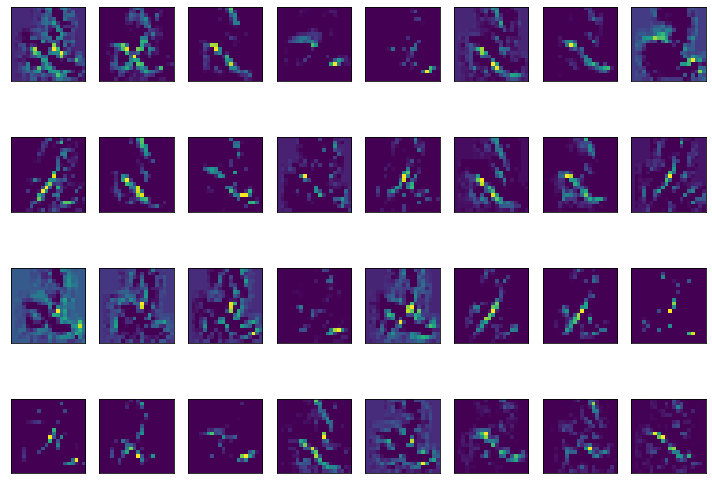

batch_normalization_17


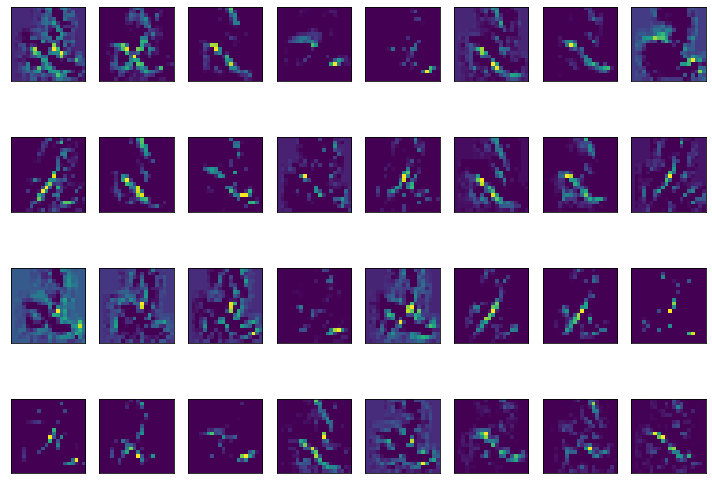

xnor_net_conv2d_14


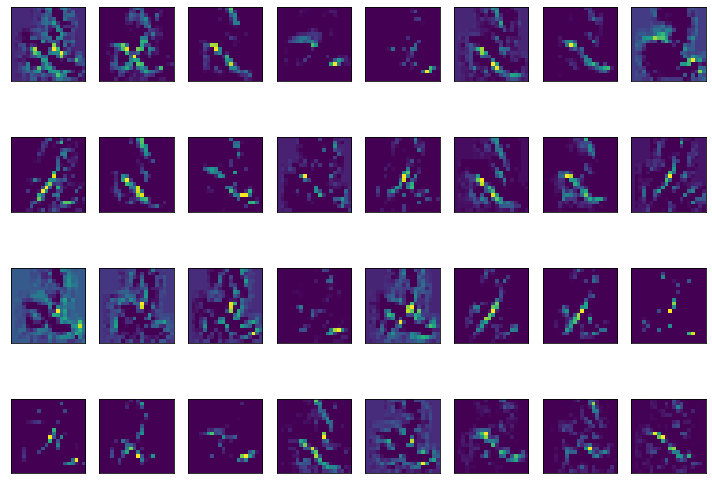

activation_17


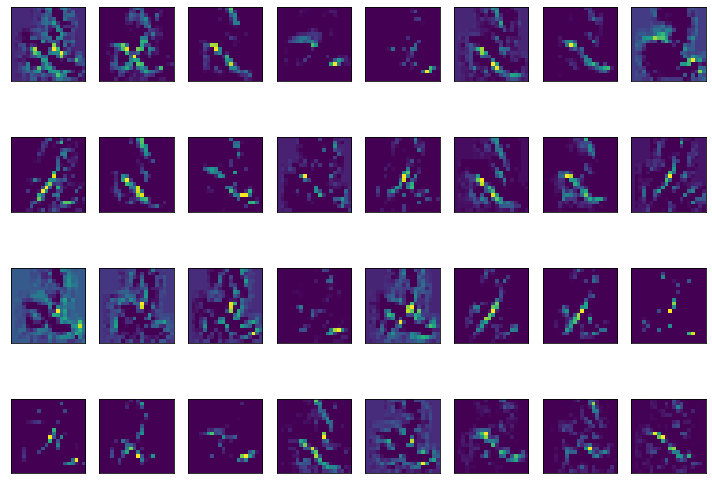

max_pooling2d_1


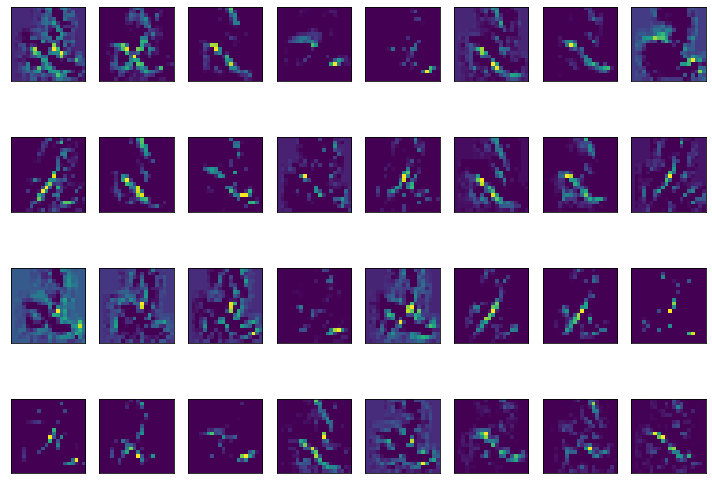

In [34]:
get_all_feature_map('results/feature_map/xnor', 3, xnorTest)

In [ ]:
get_all_feature_map('results/feature_map/bnn', 3, bnn_model)

In [29]:
i = 8
w=xnorTest.layers[i].get_weights()
print(xnorTest.layers[i].name)
print(w)

xnor_net_conv2d_1
[array([[[[-0.0754307 ,  0.07330088,  0.07147755, ..., -0.06467071,
          -0.07541004,  0.07690893],
         [ 0.0754307 , -0.07330088, -0.07147755, ...,  0.06467071,
           0.07541004, -0.07690893],
         [-0.0754307 ,  0.07330088,  0.07147755, ...,  0.06467071,
           0.07541004, -0.07690893],
         ...,
         [ 0.0754307 , -0.07330088, -0.07147755, ...,  0.06467071,
           0.07541004, -0.07690893],
         [ 0.0754307 ,  0.07330088,  0.07147755, ..., -0.06467071,
           0.07541004,  0.07690893],
         [-0.0754307 , -0.07330088, -0.07147755, ..., -0.06467071,
           0.07541004, -0.07690893]],

        [[-0.0754307 ,  0.07330088,  0.07147755, ..., -0.06467071,
           0.07541004,  0.07690893],
         [ 0.0754307 ,  0.07330088,  0.07147755, ..., -0.06467071,
           0.07541004,  0.07690893],
         [ 0.0754307 ,  0.07330088,  0.07147755, ..., -0.06467071,
           0.07541004, -0.07690893],
         ...,
         [ 0.07

In [24]:
w

[array([1.038556  , 0.90999395, 0.9640034 , 0.8372867 , 1.0878832 ,
        1.0651568 , 0.99321085, 1.0376084 , 1.1436778 , 1.0865388 ,
        1.0792929 , 0.8542558 , 1.0891918 , 1.241434  , 1.1074927 ,
        0.8378111 ], dtype=float32),
 array([ 0.19260725,  0.03010943, -0.17688076,  0.0351822 , -0.13960436,
         0.08482985, -0.08979359,  0.0918741 ,  0.17265403,  0.35017285,
        -0.169636  , -0.10637652,  0.01965036,  0.1282287 ,  0.29786888,
        -0.10936576], dtype=float32),
 array([0.2602261 , 0.31451708, 0.29081833, 0.26574796, 0.4250585 ,
        0.31414977, 0.38680005, 0.22564578, 0.2995235 , 0.34678298,
        0.35998237, 0.22316448, 0.37112305, 0.34527755, 0.39372736,
        0.25139725], dtype=float32),
 array([0.29624236, 0.63167614, 0.4792242 , 0.4609544 , 0.05823266,
        0.7341405 , 0.1280954 , 0.09637947, 0.27494636, 0.7389054 ,
        0.07108442, 0.350296  , 0.144544  , 0.22350596, 0.8521561 ,
        0.45656094], dtype=float32)]

In [14]:
import cv2

In [17]:
path = './results/feature_map/xnor/14_xnor_net_conv2d_13.png'
img = cv2.imread(path)
orig = img.copy()

In [31]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
thresh = 50
bw = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)[1]

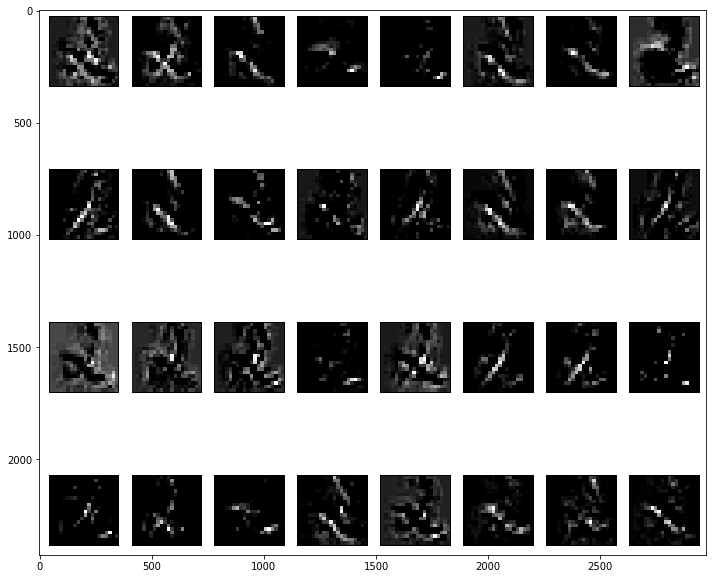

In [28]:
plt.figure(figsize=(10,10),tight_layout=1)
plt.imshow(gray, cmap='gray',interpolation='none')
# plt.savefig(f"{path}/{i}_{layer}.png", bbox_inches='tight', dpi=300)
plt.show()

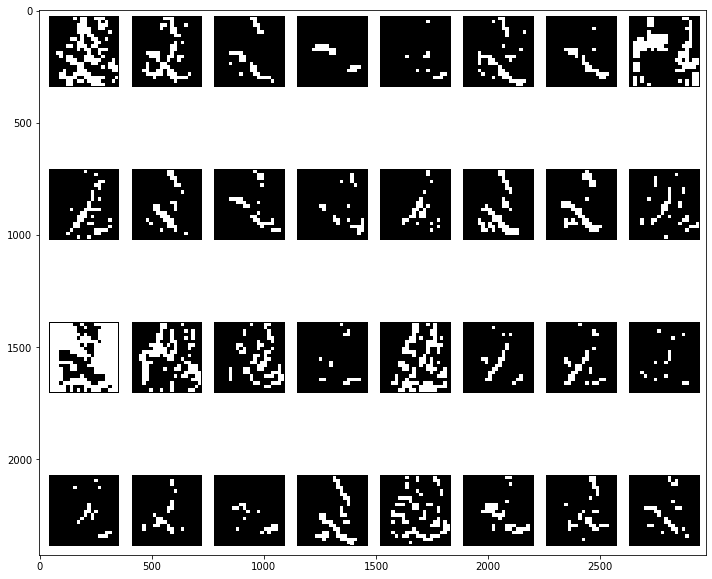

In [32]:
plt.figure(figsize=(10,10),tight_layout=1)
plt.imshow(bw, cmap='gray',interpolation='none')
# plt.savefig(f"{path}/{i}_{layer}.png", bbox_inches='tight', dpi=300)
plt.show()

In [37]:
cv2.imwrite("results/feature_map/xnor_binary_feature_map.jpg",bw)

True